In [50]:
import torchvision
import torch
import PIL.Image
import matplotlib.pyplot as plt
import pandas
import pytorch_lightning as L
from pathlib import Path
from torchvision.transforms import v2
from torch.utils import data
from matplotlib.patches import Rectangle

In [51]:
train_labels = pandas.read_csv('./data/banana-detection/bananas_train/label.csv')
train_labels

,img_name,label,xmin,ymin,xmax,ymax
0,0.png,0,104,20,143,58
1,1.png,0,68,175,118,223
2,2.png,0,163,173,218,239
3,3.png,0,48,157,84,201
4,4.png,0,32,34,90,86
...,...,...,...,...,...,...
995,995.png,0,171,101,214,147
996,996.png,0,42,57,83,96
997,997.png,0,47,54,86,109
998,998.png,0,43,125,90,166


In [52]:
class BananaDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir: str, transform: v2.Transform = None):
        super().__init__()
        self.labels = pandas.read_csv(Path(data_dir) / Path('label.csv'))
        self.image_root = Path(data_dir) / Path("images")
        self.transform = transform

    def __getitem__(self, index):
        label = self.labels.loc[index]
        image = PIL.Image.open(self.image_root / Path(label['img_name']))
        if self.transform != None:
            image = self.transform(image)
        label = torch.tensor([0, label['xmin'] / 256, label['ymin'] /
                             256, label['xmax'] / 256, label['ymax'] / 256]).reshape(1, 5)
        return image, label

    def __len__(self):
        return len(self.labels)

In [53]:
class BananaDetection(L.LightningDataModule):
    def __init__(self, data_dir: str = "./data/banana-detection/", batch_size: int = 128, image_size: tuple[int, int] = (256, 256), num_workers: int = 16):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_workers = num_workers
        self.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, True),
            v2.Resize(self.image_size)
        ])

    def prepare_data(self):
        return super().prepare_data()

    def setup(self, stage):
        self.train_dataset = BananaDetectionDataset(
            Path(self.data_dir) / Path("bananas_train"), self.transform)
        self.valiation_dataset = BananaDetectionDataset(
            Path(self.data_dir) / Path("bananas_val"), self.transform)

    def train_dataloader(self):
        return data.DataLoader(self.train_dataset, self.batch_size, True, num_workers=self.num_workers)

    def val_dataloader(self):
        return data.DataLoader(self.valiation_dataset, self.batch_size, False, num_workers=self.num_workers)

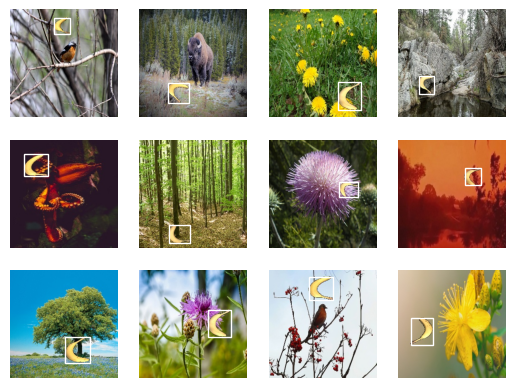

In [54]:
dataset = BananaDetection()
dataset.prepare_data()
dataset.setup('train')

train_set = dataset.train_dataset

fig, ax = plt.subplots(3, 4)

for r in range(0, 3):
    for c in range(0, 4):
        plot_ax = ax[r][c]
        img, label = train_set[r*4+c]
        plot_ax.imshow(v2.ToPILImage()(img))
        rect = Rectangle((label[0][1] * 256, label[0][2] * 256), (label[0][3]*256-label[0][1]*256),
                         (label[0][4]*256-label[0][2]*256), linewidth=1, edgecolor='w', facecolor='none')
        plot_ax.add_patch(rect)
        plot_ax.axis('off')